# Checks nans in the streamflow & forcing data
Originally written by 2022 SI team
- Lauren A. Bolotin; San Diego State University; lbolotin3468@sdsu.edu
- Francisco Haces-Garcia; University of Houston; fhacesgarcia@uh.edu
- Mochi Liao; Duke University; mochi.liao@duke.edu
- Qiyue Liu; University of Illinois at Urbana-Champaign; qiyuel3@illinois.edu

Modified by 
- Ryoko Araki (San Diego State University & UCSB, raraki8159@sdsu.edu) in 2023 SI


# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
import yaml

## Read in config for the file path 

In [12]:
# Read the config file
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Define path

In [13]:
data_dir = config['io_dir']['gauch_2020_dir'].replace("${cwd}", "..")
obs_dir = config['io_dir']['usgs_streamflow_dir'].replace("${cwd}", "..")
forcing_path = config['io_dir']['nldas_forcing_dir'].replace("${cwd}", "..")
time_split_file = config['model_settings']['time_split_file'].replace("${cwd}", "..")
missing_data_file = config['model_settings']['missing_data_file'].replace("${cwd}", "..")
missing_data_file_testing = config['model_settings']['missing_data_file_testing'].replace("${cwd}", "..")
basin_file = config['model_settings']['basin_file'].replace("${cwd}", "..")
output_dir = data_dir

# Define functions

In [4]:

def load_basin_list(basin_file):
    with open(basin_file, 'r') as file:
        lines = file.readlines()
    lines = [line.strip() for line in lines]
    return lines

def load_csv(file_path):
    return pd.read_csv(file_path)

def calc_nan_percentages_forcing(forcing_data, fields):
    return [len(np.where(np.isnan(forcing_data[field]))[0]) / len(forcing_data[field]) for field in fields]

def calc_nan_percentages_obs(obs_data):
    return len(np.where(np.isnan(obs_data['QObs(mm/h)'].values))[0]) / len(obs_data['QObs(mm/h)'])

def calc_indices(data, datetime):
    start_idx = np.where(data['date'] == datetime["start_datetime"])
    end_idx = np.where(data['date'] == datetime["end_datetime"])
    return start_idx, end_idx

def initialize_nan_check():
    keys = [
            'basin_id', 
            'spinup-for-calibration - pet', 
            'spinup-for-calibration - precip', 
            'spinup-for-testing - pet', 
            'spinup-for-testing - precip', 
            'calibration - pet', 
            'calibration - precip', 
            'calibration - usgs', 
            'testing - pet', 
            'testing - precip', 
            'testing - usgs'
            ]
    return {key: [] for key in keys}


# Get a stats on NaN data

In [48]:
import warnings
def process_data(data_dir, obs_dir, forcing_path, time_split_file, output_dir):
    
    nan_check = initialize_nan_check()

    basin_list = load_basin_list(os.path.join(data_dir, 'basin_list_516.txt'))
    time_split = json.load(open(time_split_file, 'r'))

    for basin in tqdm(basin_list):
        nan_check[f'basin_id'].append(basin)
        
        obs_data = load_csv(os.path.join(obs_dir, f'{basin}-usgs-hourly.csv'))
        forcing_data = load_csv(os.path.join(forcing_path, f'{basin}_hourly_nldas.csv'))

        for phase, fields in time_split.items():
            
            # Forcing 
            start_idx_forcing, end_idx_forcing = calc_indices(forcing_data, fields)
            if start_idx_forcing[0].size == 0 or end_idx_forcing[0].size == 0: 
                warnings.warn(f"none or missing forcing data for {phase} period")
                nan_perc = [1, 1]
            else:
                sliced_forcing_data = forcing_data.iloc[start_idx_forcing[0][0]:end_idx_forcing[0][0]+1,:]
                nan_perc = calc_nan_percentages_forcing(sliced_forcing_data, ['potential_evaporation', 'total_precipitation'])
            
            nan_check[f'{phase} - pet'].append(nan_perc[0])
            nan_check[f'{phase} - precip'].append(nan_perc[1])
            
            if "spinup" not in phase:
                # Observation
                start_idx_obs, end_idx_obs = calc_indices(obs_data, fields)
                if start_idx_obs[0].size == 0 or end_idx_obs[0].size == 0: 
                    warnings.warn(f"none or missing observation data for {phase} period")
                    nan_perc_obs = 1
                else:
                    sliced_obs_data = obs_data.iloc[start_idx_obs[0][0]:end_idx_obs[0][0]+1,:]
                    nan_perc_obs = calc_nan_percentages_obs(sliced_obs_data)
                nan_check[f'{phase} - usgs'].append(nan_perc_obs)

    df = pd.DataFrame(nan_check)
    df.to_csv(os.path.join(output_dir, "check_for_nan_in_data_hourly.csv"))

process_data(data_dir, obs_dir, forcing_path, time_split_file, output_dir)



  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 1/516 [00:02<18:38,  2.17s/it]


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

# Get the list of basins with missing data
Set the threshold in the following cell (Currently set as 50%)

In [17]:
# df is the DataFrame obtained from your code
nan_stats = pd.read_csv(os.path.join(output_dir, "check_for_nan_in_data_hourly.csv"))
nan_stats_calib = nan_stats[['basin_id', 'calibration - usgs']].copy()

In [18]:
threshold = 0.99 # set the threshold
mask = (nan_stats_calib['calibration - usgs'] > threshold)  # filter the DataFrame, ignore the 'basin id' column
basin_ids = nan_stats_calib.loc[mask, 'basin_id'].tolist()  # get the 'basin id' of the rows that meet the condition
basin_ids
print(basin_ids)
print(len(basin_ids))


[1552000, 1552500, 1567500, 1632000, 6344600, 6350000, 6352000, 6470800, 7301410, 7315700, 7346045, 8050800, 8101000, 8104900, 8109700, 8158810]
16


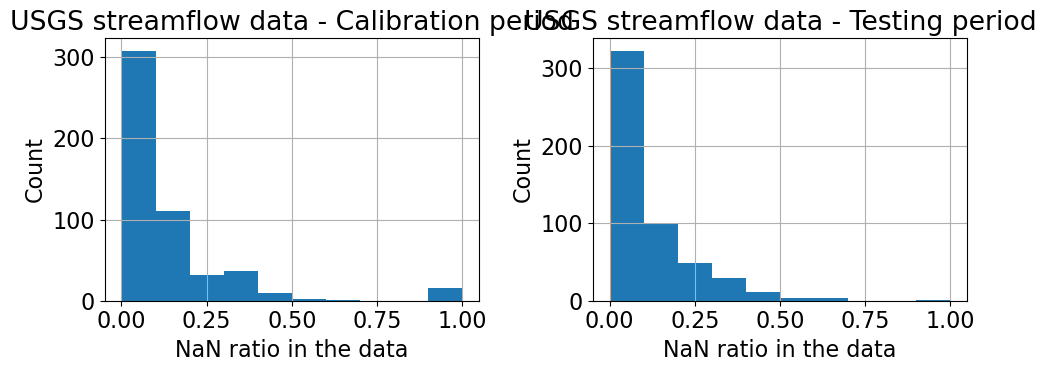

In [51]:
import matplotlib.pyplot as plt
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the first histogram
hist_cal = nan_stats['calibration - usgs'].hist(ax=axes[0])
hist_cal.set_xlabel('NaN ratio in the data')
hist_cal.set_ylabel('Count')
hist_cal.set_title('USGS streamflow data - Calibration period')

# Plot the second histogram
hist_test = nan_stats['testing - usgs'].hist(ax=axes[1])
hist_test.set_xlabel('NaN ratio in the data')
hist_test.set_ylabel('Count')
hist_test.set_title('USGS streamflow data - Testing period')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Save the list of basin id with more than threshold misssing data

### For the calibration period

In [22]:
sorted_id_list = sorted(basin_ids)
basin_ids_string = [str(basin_id).zfill(8) for basin_id in sorted_id_list]
with open(missing_data_file, 'w') as file:
    for item in basin_ids_string:
        file.write("%s\n" % item)

### Do the same thing for the testing period

In [21]:
threshold = 0.99 # set the threshold
nan_stats_test = nan_stats[['basin_id', 'testing - usgs']].copy()
mask = (nan_stats_test['testing - usgs'] > threshold)  # filter the DataFrame, ignore the 'basin id' column
basin_ids_testing_ = nan_stats_test.loc[mask, 'basin_id'].tolist()  # get the 'basin id' of the rows that meet the condition
print(basin_ids_testing_)
print(len(basin_ids_testing_))

basin_ids_testing = np.concatenate([basin_ids_testing_, basin_ids])
print(basin_ids_testing)
print(len(basin_ids_testing))


[9386900]
1
[9386900 1552000 1552500 1567500 1632000 6344600 6350000 6352000 6470800
 7301410 7315700 7346045 8050800 8101000 8104900 8109700 8158810]
17


In [14]:
sorted_id_list = sorted(basin_ids_testing)
basin_ids_string = [str(basin_id).zfill(8) for basin_id in sorted_id_list]
with open(missing_data_file_testing, 'w') as file:
    for item in basin_ids_string:
        file.write("%s\n" % item)

# Save the list of basin id with less than threshold missing data 
Gauch et al., (2020) used 516 basins (saved as "basin_list_516.txt")  
By removing the basin with >50% missing data (saved as "basin_list_missing_data_v2023.txt"),  
we get 500 basins for this project (saved as "basin_list_500.txt")  

In [29]:
with open(os.path.join(data_dir,'basin_list_516.txt'), 'r') as file1, open(os.path.join(data_dir, 'basin_list_missing_data_v2023.txt'), 'r') as file2:
    basin_ids_516 = set(map(int, file1.read().splitlines()))
    basin_ids_missing = set(map(int, file2.read().splitlines()))
    
filtered_basin_ids = list(basin_ids_516 - basin_ids_missing)
filtered_basin_ids_string = [str(basin_id).zfill(8) for basin_id in filtered_basin_ids]

# with open(os.path.join(data_dir,'basin_list_500.txt'), 'w') as file:
#     file.write('\n'.join(map(str, filtered_basin_ids_string)))


# (Skip this, just for checking)
# Checking timeseries of data to see how missing data looks like

In [24]:
obs_dir = os.path.join(data_dir, 'usgs_streamflow')
obs_data = pd.read_csv(os.path.join(obs_dir, '01022500-usgs-hourly.csv'))
obs_data.set_index(pd.to_datetime(obs_data['date']), inplace=True)
obs_data.head()

,date,QObs(mm/h),QObs count,qualifiers,utcoffset(h),(iv-camels)/camels,QObs_CAMELS(mm/h)
date,,,,,,,
1989-10-01 04:00:00,1989-10-01 04:00:00,0.027234,3,A [92]/A [92]/A [92],-4.0,-0.00989,0.025846
1989-10-01 05:00:00,1989-10-01 05:00:00,0.027234,4,A [92]/A [92]/A [92]/A [92],-4.0,-0.00989,0.025846
1989-10-01 06:00:00,1989-10-01 06:00:00,0.026887,4,A [92]/A [92]/A [92]/A [92],-4.0,-0.00989,0.025846
1989-10-01 07:00:00,1989-10-01 07:00:00,0.026887,4,A [92]/A [92]/A [92]/A [92],-4.0,-0.00989,0.025846
1989-10-01 08:00:00,1989-10-01 08:00:00,0.026887,4,A [92]/A [92]/A [92]/A [92],-4.0,-0.00989,0.025846


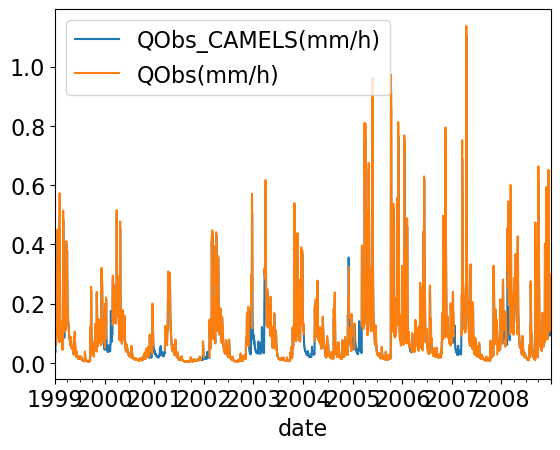

In [25]:
p1 = obs_data['QObs_CAMELS(mm/h)']['1999-01-01':'2008-12-31'].plot()
p2 = obs_data['QObs(mm/h)']['1999-01-01':'2008-12-31'].plot()
p1.legend()
p2.legend()

<Axes: xlabel='date'>

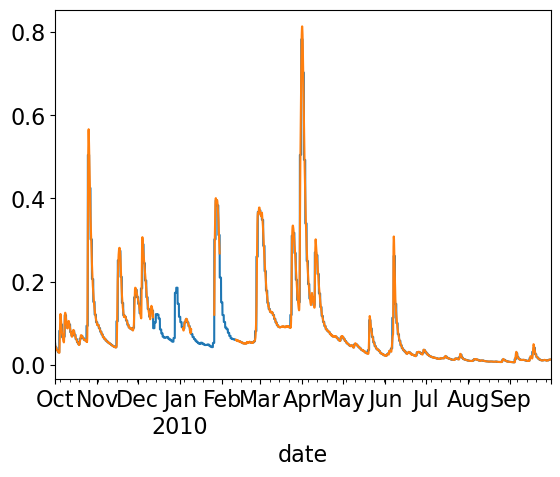

In [26]:
obs_data['QObs_CAMELS(mm/h)']['2009-10-01':'2010-09-30'].plot()
obs_data['QObs(mm/h)']['2009-10-01':'2010-09-30'].plot()